In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import matplotlib.pyplot as plt


In [2]:
# 计算带宽 - Silverman's 规则
def silverman_bandwidth(data):
    """
    根据 Silverman's 规则计算核密度估计的带宽。
    :param data: 输入数据 (numpy array)
    :return: 计算的带宽值
    """
    std_dev = np.std(data)  # 数据的标准差
    n = len(data)           # 数据样本数量
    bandwidth = 1.06 * std_dev * n**(-1/5)
    return bandwidth

In [3]:
# 核密度估计函数
def compute_kde(data, bandwidth='silverman'):
    """
    计算数据的核密度估计。
    :param data: 输入数据 (numpy array)
    :param bandwidth: 带宽 ('silverman' 或 'scott' 或具体值)
    :return: 核密度估计对象
    """
    if bandwidth == 'silverman':
        bandwidth = silverman_bandwidth(data)
    kde = gaussian_kde(data, bw_method=bandwidth)
    return kde

In [4]:
# KL散度计算函数
def compute_kl_divergence(kde1, kde2, xmin, xmax, num_points=10000):
    """
    计算两个核密度估计之间的KL散度。
    :param kde1: 第一个核密度估计对象
    :param kde2: 第二个核密度估计对象
    :param xmin: 估计范围的最小值
    :param xmax: 估计范围的最大值
    :param num_points: 用于积分的点数
    :return: KL散度值
    """
    x = np.linspace(xmin, xmax, num_points)
    p = kde1(x)
    q = kde2(x)
    p[p == 0] = 1e-10  # 避免对数出现零
    q[q == 0] = 1e-10
    kl_div = np.sum(p * np.log(p / q)) * (xmax - xmin) / num_points
    return kl_div

In [5]:
# 判断数据收敛的关键函数
def determine_data_sufficiency(data, epsilon=1e-4, increment=100, bandwidth='silverman'):
    """
    判断数据是否足够通过KL散度收敛。
    :param data: 输入数据 (numpy array)
    :param epsilon: KL散度收敛阈值
    :param increment: 每次增加的数据量
    :param bandwidth: KDE的带宽设置 ('silverman', 'scott' 或具体值)
    :param total_num_data: length of all data
    :return: 收敛时的数据量
    """
    n = len(data)
    for i in range(increment, n, increment):
        kde1 = compute_kde(data[:i], bandwidth)
        kde2 = compute_kde(data[:i + increment], bandwidth)
        xmin, xmax = min(data[:i]), max(data[:i])

        # 生成x范围上的KDE结果
        x = np.linspace(xmin, xmax, n)
        p = kde1(x)
        q = kde2(x)

        # 归一化KDE结果
        dx = (xmax - xmin) / len(x)
        p_normalized = p / (np.sum(p) * dx)
        q_normalized = q / (np.sum(q) * dx)

        # 计算KL散度
        p_normalized = np.where(p_normalized > 0, p_normalized, 1e-10)
        q_normalized = np.where(q_normalized > 0, q_normalized, 1e-10)
        kl_div = np.sum(p_normalized * np.log(p_normalized / q_normalized)) * dx

        # 判断是否收敛
        if kl_div < epsilon:
            return i
       
    return n

In [6]:
# 可视化一个特征的核密度估计随数据量变化的情况
def plot_kde_convergence(data, increments, bandwidth='silverman'):
    plt.figure(figsize=(10, 6))
    for i in range(1, len(data)//increments + 1):
        kde = compute_kde(data[:i * increments], bandwidth)
        x = np.linspace(min(data), max(data), 1000)
        plt.plot(x, kde(x), label=f"Data size: {i * increments}")
    plt.title("KDE Convergence with Increasing Data Size")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

x 坐标的足够数据量: 2000
y 坐标的足够数据量: 2200
速度的足够数据量: 5200


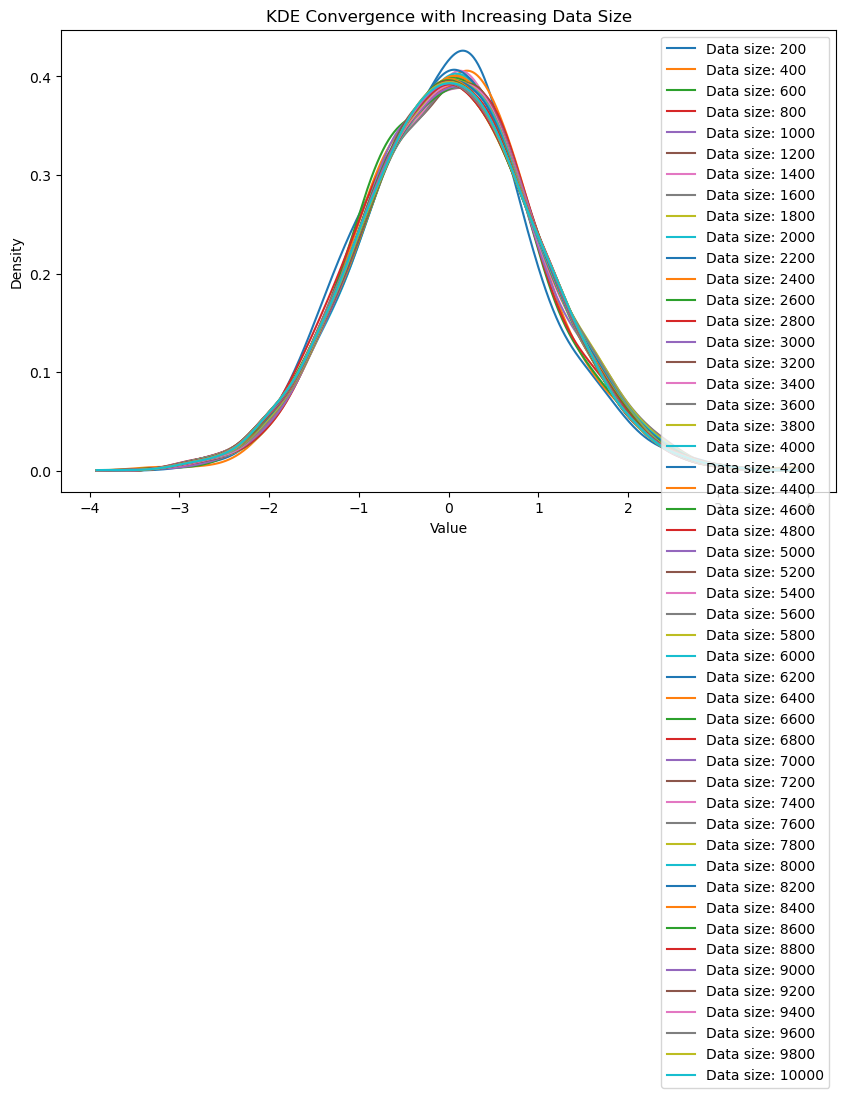

In [7]:
# 示例：鼠标序列数据的分析

# 在这里读数据===========
np.random.seed(42)
mouse_x = np.random.normal(0, 1, 10000)  # 模拟鼠标x坐标
mouse_y = np.random.normal(0, 1, 10000)  # 模拟鼠标y坐标
mouse_speed = np.abs(np.random.normal(0.5, 0.2, 10000))  # 模拟鼠标速度
#===========

#=========修改这个=========
# 分别对每个特征判断数据收敛量
sufficient_x = determine_data_sufficiency(mouse_x, epsilon=1e-4, increment=200)
sufficient_y = determine_data_sufficiency(mouse_y, epsilon=1e-4, increment=200)
sufficient_speed = determine_data_sufficiency(mouse_speed, epsilon=1e-4, increment=200)

# 输出结果
print(f"x 坐标的足够数据量: {sufficient_x}")
print(f"y 坐标的足够数据量: {sufficient_y}")
print(f"速度的足够数据量: {sufficient_speed}")


plot_kde_convergence(mouse_x, increments=200)
